# Chainer Quick Handson

この資料は2019年5月24日に実施したハンズオンに使用したものです。

スライド資料はこちらで閲覧できます。<br/>
https://www.slideshare.net/belltailjp/2019524-chainer

これは、Colaboratoryを使用したChainerハンズオンの資料を参考に、時間の圧縮とアレンジを加えたものです。<br/>
https://git.io/fjRiw

![title-slide](https://image.slidesharecdn.com/handsonpart-190528034902/95/2019524-chainer-1-638.jpg)

In [1]:
import chainer
import chainer.links as L
import chainer.functions as F
from chainer import iterators
from chainer.training import extensions

import cupy
import numpy as np
import PIL

# Chainerのバージョンを確認

In [2]:
chainer.print_runtime_info()

Platform: Linux-4.15.0-39-generic-x86_64-with-debian-buster-sid
Chainer: 6.0.0
NumPy: 1.16.3
CuPy:
  CuPy Version          : 6.0.0
  CUDA Root             : /usr/local/cuda
  CUDA Build Version    : 10000
  CUDA Driver Version   : 10000
  CUDA Runtime Version  : 10000
  cuDNN Build Version   : 7500
  cuDNN Version         : 7500
  NCCL Build Version    : 2402
  NCCL Runtime Version  : 2402
iDeep: Not Available


2019年5月現在ではChainerおよびCupyはともにv6.0.0が最新版です。

# データセットを取得し、中身を確認

今回は、基本的な画像分類データセットであるCIFAR10で画像分類CNNの学習にトライしてみます。

CIFAR10は、32x32ピクセルのRGB画像を10クラスに分類するデータセットで、CNNの基礎を学習する際によく用いられます。

![CIFAR10](figures/cifar10.png)

## CIFAR10の学習データとバリデーションデータを取得する

![train/val](https://image.slidesharecdn.com/handsonpart-190528034902/95/2019524-chainer-10-638.jpg)

深層学習モデルを研究・開発する場合は自分で学習データを準備する必要があります。

CIFAR10のような典型的なデータセットについては、Chainerも含めほとんどの深層学習フレームワークが自動でダウンロード・パースする機能があります。

下記のコードでは、（初回では）データセットのダウンロード（162MB）、Chainerにとって使いやすいフォーマットへの変換をした上で、学習用と検証用データに分割された状態で取得することができます。

In [3]:
cifar10 = chainer.datasets.get_cifar10()
train, val = cifar10

下記で確認できるように、trainおよびvalはともにlistになっています（正確には違うのですが、listのように使えます）。<br/>
CIFAR10では学習データが50000枚、検証用データが10000枚なので、trainは50000要素、valは10000要素のlistです。

各要素は、次で確認できるように、3x32x32のarrayと、数字1つがペアになったtupleです。<br/>
arrayは画像データでその大きさは3x32x32であることがわかります。数字はその画像の属する真のクラスの番号です。

In [4]:
print(train[0])
print(train[0][0].shape)

(array([[[0.23137257, 0.16862746, 0.19607845, ..., 0.61960787,
         0.59607846, 0.5803922 ],
        [0.0627451 , 0.        , 0.07058824, ..., 0.48235297,
         0.4666667 , 0.4784314 ],
        [0.09803922, 0.0627451 , 0.19215688, ..., 0.46274513,
         0.47058827, 0.427451  ],
        ...,
        [0.81568635, 0.78823537, 0.77647066, ..., 0.627451  ,
         0.21960786, 0.20784315],
        [0.7058824 , 0.6784314 , 0.7294118 , ..., 0.72156864,
         0.3803922 , 0.3254902 ],
        [0.69411767, 0.65882355, 0.7019608 , ..., 0.8470589 ,
         0.5921569 , 0.48235297]],

       [[0.24313727, 0.18039216, 0.18823531, ..., 0.5176471 ,
         0.4901961 , 0.48627454],
        [0.07843138, 0.        , 0.03137255, ..., 0.34509805,
         0.3254902 , 0.34117648],
        [0.09411766, 0.02745098, 0.10588236, ..., 0.32941177,
         0.32941177, 0.28627452],
        ...,
        [0.6666667 , 0.6       , 0.6313726 , ..., 0.52156866,
         0.12156864, 0.13333334],
        [0.

#### HWCとCHW

ちなみにOpenCVなどで画像を読むと、その大きさは `(32, 32, 3)` となります。<br/>
つまり、各軸が(高さH、幅W、チャンネル数C(=3, RGB))ということです。これをHWC配列と呼ぶことがよくあります。

Chainerや多くの深層学習フレームワークでは `(3, 32, 32)` つまりCHW配列が必要なので、numpy/cupyの `transpose` によって並べ替えを行う必要があります。

今回の例では `get_cifar10` ですでにCHW化された状態で返るので不要ですが、自分で画像を使ったNNを実装する際には必ず通る道なので、そんな話もあるなと覚えておくとよいでしょう。

----

さて、クラス番号だけではそれが車を意味するのか飛行機を意味するのかわかりにくいので、番号とクラス名の対応付けを定義します。

CIFAR10では上のサンプル画像の順番のまま、クラス0が飛行機、クラス1が車…と定義されているので、それをラベル定義リストにします。

In [5]:
cifar10_labels = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

データセットが正常にちゃんと読めているか不安なので、1サンプルを渡すとそのラベルと画像を表示してくれる関数を実装してみましょう。

中でやっていることを詳しく説明すると（読み飛ばしてOKです）：
* 画像に戻すためCHWをHWCに戻す
* また画像の各画素は通常0-255の整数値を持ちますが、NNで扱いやすいように0-1に変換された状態なので、表示するためにこれを0-255に戻す
* 画像はPillow (PIL)というパッケージで扱い、arrayをこのPILの画像形式に読み込む

truck


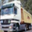

In [6]:
def show(x, t):
    img = x.transpose(1, 2, 0)
    import PIL

    print(cifar10_labels[t])
    return PIL.Image.fromarray((img * 255).astype(np.uint8))

show(*train[1])

学習画像1番目のサンプルはトラックであることが画像とラベルから確認できるかと思います。

# CNNで画像分類器の学習

事前に必要なものは揃ったので、CNNを使って画像分類器を実装し学習してみます。

下記に、これから実装するCNNの主な構成要素について概説しています。

* 畳み込み層
* 発火関数
* プーリング

これらはいずれも、最先端のCNNも含めほとんど常に使われている概念なので、ぜひ理解してください。

### 2次元畳み込み層 (`L.Convolution2D`)
畳み込み層とは、入力データに対して[畳み込み](https://ja.wikipedia.org/wiki/%E7%95%B3%E3%81%BF%E8%BE%BC%E3%81%BF)演算を行う層のことです。今回は画像に適用するということで、特に2次元の場合について説明します。

言葉で説明するよりは画像を利用したほうが直感的に理解できると思います。<br/>
この図は下側が入力配列、上側が出力配列を表していて、下記のような挙動を説明しています。
* フィルタの大きさは3x3
    * 3x3のフィルタを、入力配列のうち今注目している3x3領域と掛け算し、総和をとり、出力の値とする
* フィルタは、入力画像を1ピクセルずつ移動しながら適用する（ストライド=1）
* 入力配列の端っこでは、1ピクセル分を0で埋める（パディングサイズ=1）

![same padding no strides](https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/same_padding_no_strides.gif)

フィルタサイズ・ストライド・パディングは全てユーザが指定可能です。<br/>
これらのパラメタの値によって出力配列のサイズが変わることがわかるかと思います。<br/>
たとえばストライドを1から2にすれば、出力配列の横幅と縦幅はおよそ半分になります。

そもそもなぜこのような畳み込み処理を画像に適用するのでしょうか。

実は画像処理では、古くから畳み込み処理により平滑化やエッジ抽出を行ってきました。
例えば、ラプラシアンフィルタは以下のようにエッジ抽出の効果があります。

![laplacian filter](https://raw.githubusercontent.com/chainer-community/chainer-colab-notebook/master/docs/images/laplacian_filter.png)

これは画像に対して「二次のエッジ」という特徴の反応をマップ化したものであり、CNNで行われる特徴の抽出と全く同じことです。

もし、あなたの実装したCNNのksize=3のフィルタ係数が以下のように学習された場合、

$$
\begin{bmatrix}
1 & 1 & 1 \\
1 & -8 & 1 \\
1 & 1 & 1 \\
\end{bmatrix}
$$

その畳み込み層も同様の役割を持つでしょう。

問題を解くために必要なフィルタの係数を人手で考えて与えるのではなくbackpropによって獲得するというのが、CNNの担っている役割です。

WikipediaのKernel_(image_processing)の項目には、他のフィルターも紹介されていますので御覧ください。

![Conv](https://image.slidesharecdn.com/handsonpart-190528034902/95/2019524-chainer-18-638.jpg)

![Conv2](https://image.slidesharecdn.com/handsonpart-190528034902/95/2019524-chainer-19-638.jpg)

### ReLU発火関数 (`F.relu`)

発火関数あるいはactivation functionは、NNに対して非線形性を与えるために必要です。

発火関数を用いずにMLPあるいはConvolutionだけでNNを構成することは、（いくら深いNNを構成しても）たった1層の大きな線形のNNを組むことと等価であり、その表現能力は著しく制約されます。

この発火関数として、元来Sigmoidが用いられていました。
Sigmoidには、その形からわかるように0付近以外はほとんど微分値が0になるという性質から、誤差逆伝搬によって深い層から勾配を伝搬するときに勾配が0になりやすいという問題がありました。<br/>
これにより、backpropを行っても浅い層（入力側の層）には何も情報は伝わらず、すなわち浅い層の学習が全く進まないという問題がありました。これは勾配消失と呼ぶ深層学習の古典的な問題です（Sigmoidの使用だけが原因ではありません）。

そこで近年ではReLU (Rectified Linear-Unit)と呼ぶ関数やその派生系が多く用いられています。<br/>
ReLUであればその形からわかるように、何層経ていても（正の数であれば）0から離れた場所でも勾配は保たれます。

![sigmoid_vs_relu](https://www.researchgate.net/profile/Robert_Mash/publication/312303454/figure/fig3/AS:450104441217026@1484324669669/Sigmoid-and-ReLU-activation-functions.png)

なおSigmoidはこれで用無しになったわけではなく、0-1の値を出力する回帰問題の出力層などでよく用いられます。

### プーリング層 (`F.max_pooling_2d`)

プーリング層は、2次元の特徴マップを集約しダウンサンプルを行う層です。

畳み込み層と同様の `ksize`、`stride`、`pad`、のパラメタで決まるウィンドウをスライドさせ、ウィンドウ内の最大値（MaxPooling）や平均値（AveragePooling）を出力とする処理です。

![max pooling](https://raw.githubusercontent.com/chainer-community/chainer-colab-notebook/master/docs/images/max_pooling.png)

* 中間結果のサイズを縮小
* 微小な位置の変化に対して特徴マップが頑健になる

などの効果があり、CNNではConvolutionをかける→MaxPoolingを適用する、といった形で広く用いられます。

### その他の層

近年のNNではBatch Normalization（バッチ正規化）という層も広く用いられます。

詳細の説明は省きますが、これは学習を安定化させたり汎化性能を向上させるために大きく寄与することから、画像認識などでは事実上ほぼ常に使われています。

加えて、dropoutという層もよく用いられています。
こちらも詳細は省きますが、適切に用いると汎化性能の向上に寄与します。

## CNNのアーキテクチャ

Convolutionを利用したCNNを実装してみましょう。

2014年に大規模画像分類タスク（ImageNet）のために提案されたVGGを参考にしたアーキテクチャを実装してみます。

![ImageNet](https://www.abtosoftware.com/assets/17.png)

VGGの技術的な貢献は、3x3の小さなフィルタでの畳み込みを積層することで、より少ない数のパラメタで広い範囲の特徴を捉える方法論を確立し、またより深いNNの学習を可能にしたことです。<br/>
（3x3フィルタを2回かけると5x5のフィルタ1回分に相当する領域の特徴を捉えられます。そのパラメタ数は3x3x2=18ですが、5x5フィルタのパラメタ数は25です）

畳み込みによって特徴次元を倍に増やしながらMaxPoolingによって特徴サイズを半分に減らしていくのが特徴的なアーキテクチャです。<br/>
比較的古いアーキテクチャですが、より新しいResNetとともに、現在でも画像特徴抽出器として非常に広く用いられています。

本来のVGGではBNは使われていませんが（VGGの発表当時はBNは未提案だったため）、今回はこのConvolution→BatchNormalization→ReLUを1つの再利用可能なモジュールとして、CNNを構成してみましょう。

この再利用可能なConvBNReLUモジュールはそれ自体が単独で動作することも可能な一つの小さなNNです。<br/>
Chainerではこのように特定の役割を担う部分NNを再利用可能モジュールとしてクラス化し、より大きなNNの一部とすることが非常に一般的に行われるので、ぜひ理解してください。

In [7]:
class ConvBNReLU(chainer.Chain):
    """
    Convolution -> BatchNormalization -> ReLUをセットにしたモジュール
    """
    
    def __init__(self, in_c, out_c):
        super(ConvBNReLU, self).__init__()
        with self.init_scope():
            self.conv = L.Convolution2D(in_c, out_c, ksize=3, stride=1, pad=1)
            self.bn = L.BatchNormalization(out_c)
            
    def forward(self, x):
        return F.relu(self.bn(self.conv(x)))


class VGGLike(chainer.Chain):
    """
    VGGに似た構造を持つCIFAR10分類用CNN
    """
    def __init__(self):
        super(VGGLike, self).__init__()
        with self.init_scope():
            # CNNを構成する各Layerのうち、学習すべきパラメタをもつものを事前用意            
            self.conv1_1 = ConvBNReLU(3, 32)
            self.conv1_2 = ConvBNReLU(32, 32)
            
            self.conv2_1 = ConvBNReLU(32, 64)
            self.conv2_2 = ConvBNReLU(64, 64)
            
            self.conv3_1 = ConvBNReLU(64, 128)
            self.conv3_2 = ConvBNReLU(128, 128)
            
            self.fc4 = L.Linear(None, 256)
            self.bn4 = L.BatchNormalization(256)
            self.fc5 = L.Linear(256, 10)

    def forward(self, x, t=None):
        """
        順伝搬の実装。
        画像を表すarrayと、その真値（正解ラベル）を受け取る。
        真値が与えられた場合は、クロスエントロピー損失を返す。
        これは学習時に用いる。
        
        真値が与えられなかった場合は、NNの出力ベクトルを返す。
        これは推論時に用いる。
        
        この切り替えは、ChainerのClassifierという機能でも実現できる。
        """
        
        h = self.conv1_1(x)
        h = self.conv1_2(h)
        h = F.max_pooling_2d(h, ksize=2, stride=2, pad=0)
        # h.shape == (batch_size, 32, 16, 16)
        
        h = self.conv2_1(h)
        h = self.conv2_2(h)
        h = F.max_pooling_2d(h, ksize=2, stride=2, pad=0)
        # h.shape == (batch_size, 64, 8, 8)
        
        h = self.conv3_1(h)
        h = self.conv3_2(h)
        h = F.max_pooling_2d(h, ksize=2, stride=2, pad=0)
        # h.shape == (batch_size, 128, 4, 4)
        
        h = F.dropout(F.relu(self.bn4(self.fc4(h))), ratio=0.5)
        h = self.fc5(h)
        
        # 真値が与えられない -> NN出力を返す
        if t is None:
            return F.softmax(h)
        
        # 真値が与えられた -> Cross entropy lossを計算し返す
        loss = F.softmax_cross_entropy(h, t)
        accuracy = F.accuracy(F.softmax(h), t)
        chainer.report({'loss': loss, 'accuracy': accuracy}, self)
        return loss
    
    def predict(self, x, topK=3):
        """
        推論用関数。
        真値を与えずに順伝搬を実行し、出力スコアの高いクラスから順にそのクラス名とスコアを表示する。
        """
        with chainer.using_config('train', False):
            y = self(x[None, :]).data
        idxs = y[0].argsort()[::-1][:topK]
        for i in idxs:
            print("{:3.3f}: {}".format(float(y[0, i]), cifar10_labels[int(i)]))

あまり複雑なNNではありませんが、Chainerのエッセンスがいくつか詰まっています。

#### Chain

NNの実装は、`chainer.Chain` クラスを継承したもので書きます。
Chainの主な役割は

* 学習すべきパラメタが何であるかを認識し管理する機能
* それらをファイルに保存するときなどに便利な機能

です。

Chainは入れ子にできる、すなわち `VGGLike` が最終的に使いたいNNをあらわすChainですが、その中で `ConvBNReLU` というChainを利用していることに注目してください。

#### ChainにLinkを登録

Chainは、学習すべきパラメタをもつ層が何であるかを教えてもらう必要があります。<br/>
クラスのイニシャライザ（コンストラクタ）`__init__` の中の `with self.init_scope():` でそれを行っています。

畳み込み層は学習すべきパラメタをもつため（このような層をChainerでは **Link** と呼んでいます）、`L.Convolution2D()` をここで呼んで登録しています。
また `VGGLike` の `__init__` で `ConvBNReLU` を登録しているように、子Chainも学習すべきパラメタをもっているため、ここで登録する必要があります。


途中で、`self.fc4 = L.Linear(None, 256)`としていることに気づかれたかもしれません。

全結合層`Linear`は入力数と出力数が決まらないと、その重みの数が決定できないはずです。<br/>
実はChainerには、入力数が指定されなかった場合（`None`であった場合）、初回の`forward`時に実際のデータの大きさを見てこの入力数を決定するという便利機能があります。`Convolution`の最初の引数`in_channels`も同様です。便利ですね！


#### Forward

実際にあなたのNNが各層をどのように実行するか（順伝搬の手順）を、`forward`関数に実装する必要があります。

`VGGLike`の`forward`の引数は、画像分類器の場合は画像の配列 `x` とそのラベル `t` です。

より正確には、あなたの使用する `Dataset` クラスの `get_example` が返す値がそのままChainerによってforwardに渡されます。
今回は `get_example` が`x`と`t`の2つの値を返すため、`VGGLike`の`forward`は2つの引数`x`と`t`を受け取るように実装しているのです。

データセットのところで説明をぼかしてしまいましたが、`get_cifar10`で返ってくるのは「リスト（のように使える何か）」といいましたが、それがすなわち`chainer.Dataset`のサブクラスです。そしてこれは`get_example`を実装しています。その返り値が`x`と`t`のタプルなので、`forward`には`x`と`t`が渡されるのです。

一方で部分NN`ConvBNReLU`は`VGGLike`から内部的に使われるだけで、その役割は`forward`が呼ばれたとき特徴マップを入力し畳み込み(など)を1回かけた特徴マップを出力すればよいため、ただ一つの引数だけを受け取るように実装しています。

`forward`を実装しているときに意識することはあまりありませんが、このforwardの処理の中で流れているデータはただの配列（numpyやcupyのarray）ではなく、Chainerの`Variable`というオブジェクトです。<br/>
これは、計算結果のデータとその計算結果がどのように生成されたか（自分を生成した層がなにか）を覚えておくためのものです。Chainerはこれを利用してNNの出力から入力側までの計算グラフを完全にたどることができ、誤差逆伝搬を行います。


#### `predict`

これはChainerで（学習の際に）必要になる関数ではありません。詳細は後述します。


#### Chainの構造

まとめとして、下記のスケルトンは自分のChainを定義するときのミニマムなコードです。

```py
class MyChain(chainer.Chain):
    def __init__(self):
        super(MyChain, self).__init__()
        with self.init_scope():
            self.conv = ...
    
    def forward(self, x):
        ...
```

### 学習コード

ここまででデータセット、CNNの実装までができたので、あとはそれをどのように回して学習するかです。

下記が完全な学習コードです。

epoch       main/loss   validation/main/loss  main/accuracy  validation/main/accuracy  elapsed_time
1           1.31109     1.1192                0.529092       0.598892                  4.32126       
2           0.883122    0.832411              0.686221       0.710641                  8.29322       
3           0.71733     0.793011              0.746474       0.725771                  12.2375       
4           0.615089    0.656997              0.783308       0.769778                  16.3322       
5           0.534859    0.789281              0.813219       0.734078                  20.6577       
6           0.458228    0.64339               0.839824       0.779767                  24.8933       
7           0.396489    0.685229              0.861153       0.778184                  28.9466       
8           0.339839    0.67271               0.880589       0.782536                  32.9574       
9           0.290566    0.673659              0.897239       0.789359               

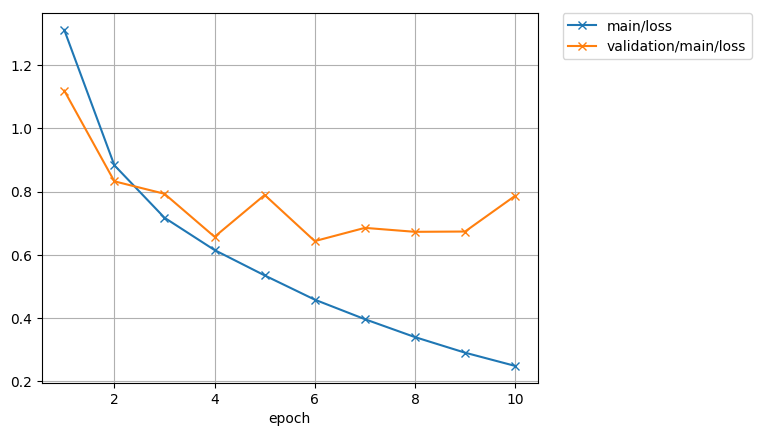

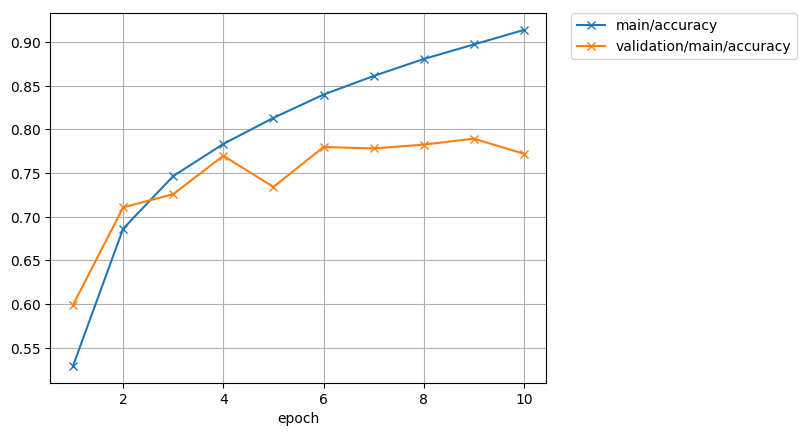

CPU times: user 42.2 s, sys: 4.54 s, total: 46.7 s
Wall time: 41.7 s


In [8]:
from IPython.display import Image, display_png

def run_train(model, train, val, batch_size, epoch, gpu=0, dest='result'):
    """
    学習を実行する関数
    """
    
    # GPUの使用を指定されていたら、そのGPUをアクティブにし、モデルをGPUに送る
    if 0 <= gpu:
        chainer.backends.cuda.get_device_from_id(gpu).use()  # Make the GPU current
        model.to_gpu()

    # 学習データと検証データを用意
    train_iter = iterators.SerialIterator(train, batch_size=batch_size, shuffle=True)
    val_iter = iterators.SerialIterator(val, batch_size=batch_size, shuffle=False, repeat=False)

    # 重みはMomentumSGDとよぶ方法で更新
    optimizer = chainer.optimizers.MomentumSGD()
    optimizer.setup(model)

    # 学習を回すTrainerを用意
    updater = chainer.training.updaters.StandardUpdater(train_iter, optimizer, converter=chainer.dataset.concat_examples, device=gpu)
    trainer = chainer.training.Trainer(updater, (epoch, 'epoch'), dest)

    # ここからは学習に直接必要のない、便利な機能（Extension）
    # 1エポックごとに、モデルの現在の性能を検証する
    trainer.extend(extensions.Evaluator(val_iter, model, converter=chainer.dataset.concat_examples, device=gpu), trigger=(1, 'epoch'))
    
    # 1エポックごとに、モデルの現在の状態（性能・平均ロスなど）を画面に出力
    trainer.extend(extensions.PrintReport([
        'epoch', 'main/loss', 'validation/main/loss',
        'main/accuracy', 'validation/main/accuracy',
        'elapsed_time',
    ]), trigger=(1, 'epoch'))
    
    # 1エポックごとに、モデルの現在の状態をJSONに記録
    trainer.extend(extensions.LogReport(trigger=(1, 'epoch')))

    # 1エポックごとに、学習曲線をPNGファイルで保存
    trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'], 'epoch', file_name='loss.png'))
    trainer.extend(extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'], 'epoch', file_name='accuracies.png'))

    # 1エポックごとに、学習されたモデルをファイルに保存
    trainer.extend(extensions.snapshot_object(model, 'model_epoch_{.updater.epoch:03d}'), trigger=(1, 'epoch'))
    
    # 学習を実行
    trainer.run()
    
    display_png(Image('{}/loss.png'.format(dest)))
    display_png(Image('{}/accuracies.png'.format(dest)))

model = VGGLike()    # CNNのオブジェクトを作成する
%time run_train(model, train, val, 128, 10)

# 学習したモデルを使った推論(`predict`関数)

モデルを学習すると、こんどはそれを実際に使用して、未知の画像に対してどのような分類結果を出すか見てみたくなります。

学習したモデルをいざ実際のデータで試すときは、単に順伝搬`forward`を引数`t`を与えずに呼べばOKです（というより、今回のクラスはそのように実装しています）。

しかしながら`forward`が返すのは各カテゴリのスコアの配列であるので、そのままでは人に解釈しにくく使いにくいです。<br/>
そこで、この出力ベクトルを活用しやすい形に解釈し直すための便利関数の例が`predict`です。名前は何でもOKです。

またこの中で重要なのは`with chainer.using_config('train', False):`のブロックの中で`forward`を実行していることです。<br/>
NNの層のなかでは学習時と推論時で挙動を切り替えなくてはいけないものがあります。<br/>
今回実装したCNNで使われているBatchNormalizationやDropoutはそうしたものの例です。うっかり学習モードで推論を走らせてしまうと、精度が著しく悪くなるというわかりにくいバグに悩むことになるでしょう。

`using_config('train', False)`はそのブロック内でChainerをグローバルに推論モードにします。<br/>
`predict`の中ではこの機能で推論モードにし結果を解釈可能な形に変換するようにしているため、ユーザは何も考えずに`predict`を呼べばよろしく推論結果が帰ってくるので便利です。

----

では、Google画像検索で適当に探してきた画像をダウンロードし、読み込んでみましょう。

すでにデータセットの説明で述べたように、画像をそのまま読み込むとHWC形式の値域0-255の配列となるので、CHW形式の値域0-1の配列に変換する作業が必要となります。

--2019-05-23 16:53:28--  https://www.airtrip.jp/travel-column/wp-content/uploads/2017/08/2f05b75878f20c5d6a5de64b37ebeb98_m.jpg
Resolving www.airtrip.jp (www.airtrip.jp)... 52.197.177.185, 13.230.171.157
Connecting to www.airtrip.jp (www.airtrip.jp)|52.197.177.185|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 179438 (175K) [image/jpeg]
Saving to: ‘airplane.jpg’

airplane.jpg        100%[===================>] 175.23K  --.-KB/s    in 0.02s   

2019-05-23 16:53:28 (7.60 MB/s) - ‘airplane.jpg’ saved [179438/179438]



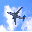

In [9]:
!wget https://www.airtrip.jp/travel-column/wp-content/uploads/2017/08/2f05b75878f20c5d6a5de64b37ebeb98_m.jpg -O airplane.jpg

img = PIL.Image.open('airplane.jpg')
img = img.resize((32, 32))
img

In [10]:
# 値域を0-255のuint8から0-1.0のfloat32にする
x = np.asarray(img, dtype=np.float32) / 255.0

# HWC配列をCHW配列にする
x = x.transpose(2, 0, 1)

`model` 変数には、ハンズオンのここまでで既に学習したモデルのパラメータなどが入っていて、すぐに直接使える状態です。<br/>
しかしここではあえて、モデルファイルを読み込む方法を示すために、`model`を作り直して、ここまでで学習したモデルファイルを読み込んでみましょう。

あとはさきほど解説した`predict`を呼ぶだけです。

In [11]:
model = VGGLike()          # この時点でmodelは未学習のNNとなっている
chainer.serializers.load_npz('result/model_epoch_010', model)         # 学習したモデルをファイルから読み込む
model.predict(x)

0.996: airplane
0.003: deer
0.001: bird


ちゃんと飛行機の画像に対してairplaneという出力結果が出ました！

もし`load_npz`にわたすモデルファイルを例えば`model_epoch_000`など学習がまだ十分進んでいないものにした場合、誤った結果が出たりするかもしれません。いろいろ遊んでみると楽しいでしょう。

# Data augmentationにトライ

![DataAug](https://image.slidesharecdn.com/handsonpart-190528034902/95/2019524-chainer-24-638.jpg)

![DataAug2](https://image.slidesharecdn.com/handsonpart-190528034902/95/2019524-chainer-25-638.jpg)

自然画の画像分類の問題においては、一般的に鏡像反転に対して不変であるべきでしょう。<br/>
この場合は学習データのうち画像を左右反転しラベルをそのまま使用した人工的なデータを加えて学習すると、モデルが鏡像反転不変の性質を得る助けになるかもしれません。

画像を50%の確率で左右反転するData Augmentationを実装してみましょう。

Chainerではリスト(list)をデータセットとして使用可能ですが、ファイルからの逐次読み込みやデータ変換などを自前で実装する場合は`DatasetMixin`クラスを自分で実装する必要があります。

`Dataset(Mixin)`クラスの必要性について：<br/>
あらゆる実験をする際に全てのデータを即NNに入力可能な形式のデータ(numpy array)にしてlistにしてメモリに置いておくということは可能でしょうが、たとえばImageNetの約100万枚の画像を無圧縮でメモリに置くことは不可能です(540GB必要！)。そこで例えばメモリには画像ファイル名だけを置いておいて、学習時はイテレーションごとにディスクから画像ファイルを読み込み→前処理をし→必要ならData augmentationをするなどの工夫が必要です。その役割を担うのがDatasetの仕組みです。

今回の例では「画像を50%の確率で左右反転する」というロジックを実装する必要があるため、下記のようなDatasetを実装しました。

In [12]:
import random

class RandomFlipLabelledImageDataset(chainer.dataset.DatasetMixin):
    def __init__(self, base_ds, random_flip=True):
        self.base_ds = base_ds
        self.random_flip = random_flip
        
    def get_example(self, i):
        """
        i番目のサンプルを返す関数
        内部で乱数を生成し50%の確率で左右反転する。
        """
        x, t = self.base_ds[i]
        if self.random_flip and random.randint(0, 1):
            x = x[:, :, ::-1]
        return (x, t)
    
    def __len__(self):
        """
        データセット全体のサンプル数を返す関数
        """
        return len(self.base_ds)

train_flip_aug = RandomFlipLabelledImageDataset(train)

ではこれで学習を実行してみましょう。

1つのサンプルがそのまま使われる場合と左右反転する場合の2通りに分かれるので、学習エポック数を2倍にしてみます。

epoch       main/loss   validation/main/loss  main/accuracy  validation/main/accuracy  elapsed_time
1           1.34521     1.11473               0.517803       0.598497                  3.87324       
2           0.912687    0.802271              0.677709       0.720332                  7.91449       
3           0.755083    0.809336              0.733694       0.722706                  12.1675       
4           0.657514    0.720977              0.768302       0.750791                  16.2776       
5           0.593359    0.626174              0.792979       0.786986                  20.3966       
6           0.541564    0.681194              0.811879       0.766317                  24.4766       
7           0.49327     0.59329               0.828305       0.7946                    28.5848       
8           0.45074     0.575626              0.842608       0.799051                  32.6075       
9           0.418845    0.566699              0.855159       0.809632               

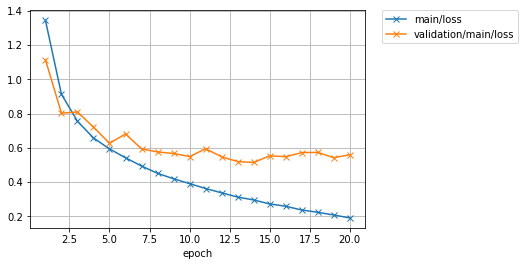

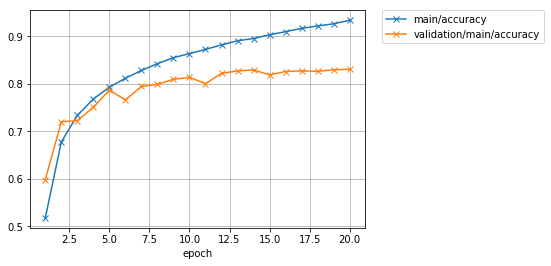

CPU times: user 1min 22s, sys: 6.74 s, total: 1min 29s
Wall time: 1min 21s


In [13]:
model = VGGLike()
%time run_train(model, train_flip_aug, val, 128, 20)

79%だった精度が、最大83%まで向上しました！

# 過学習を体験してみる

![overfitting](https://image.slidesharecdn.com/handsonpart-190528034902/95/2019524-chainer-28-638.jpg)

過学習とは、モデルが学習データに対して過剰に最適化されてしまい、未知のデータに対する推定精度が落ちてしまった状態（汎化性能が低くなった状態）です。

これが起こる原因は多種多様ですが、もっとも典型的な原因の一つは学習データの不足です。これをCIFAR10で擬似的に体験してみましょう。

epoch       main/loss   validation/main/loss  main/accuracy  validation/main/accuracy  elapsed_time
1           1.948       1.66535               0.311133       0.385087                  0.624211      
2           1.44742     1.44504               0.472556       0.479925                  1.54519       
3           1.23393     1.77204               0.549679       0.4196                    2.4333        
4           1.05144     1.31279               0.63121        0.531646                  3.32214       
5           0.862531    1.23759               0.697115       0.548952                  4.20857       
6           0.736057    1.25396               0.751202       0.563192                  5.10258       
7           0.585681    1.48903               0.80629        0.511867                  6.01242       
8           0.467384    1.25575               0.851763       0.57496                   6.90908       
9           0.34212     1.3118                0.899038       0.573576               

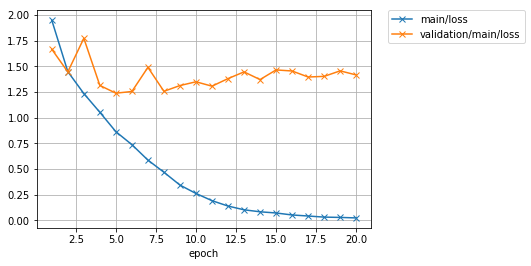

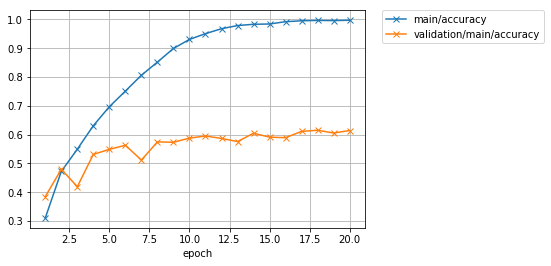

CPU times: user 19.8 s, sys: 5.58 s, total: 25.3 s
Wall time: 17.9 s


In [14]:
train_small = list(train)[:5000]   # 5万枚の学習データを5000枚にしてみる

model = VGGLike()
%time run_train(model, train_small, val, 128, 20)

# Challenge

今回のモデルでは83%程度の精度でしたが、モデル構造や学習方法などを工夫することでさらに大幅に精度を向上することができます。<br/>
比較的単純な工夫をいくつか組み合わせるだけで、90%は余裕で超えることができます。

しかしながら95%程度のテスト精度を達成するには最新の各種技法を複数理解し実装する必要があります。<br/>
深層学習について学ぶためには程よくチャレンジングで、ちょうどよい目標になるでしょう。

最先端の手法では97%を超えるテスト精度を叩き出しています。<br/>
ちなみに人の精度は94%程度と言われています。
<br/>（人でさえ94%なのに真値は信頼できるのか？と思われるかもしれませんが、真値は32x32に縮小する前の大きな画像を見てつけられているため、ご心配なく！）

![cifar10sota](https://image.slidesharecdn.com/handsonpart-190528034902/95/2019524-chainer-31-638.jpg)

----

# ChainerCVにトライ

Chainer familyの一つに、画像認識関連の最新手法の再現実装などをまとめたChainerCVというパッケージがあります。

一般物体認識などの典型的なタスクを単に利用したいだけの場合は、わざわざ自分で最新の手法を実装するなどする必要はなく、ChainerCVを利用してその出力を活用すれば間に合うかもしれません。

先程ダウンロードした飛行機の画像を対象に、SSDという物体検出手法を適用してみましょう。

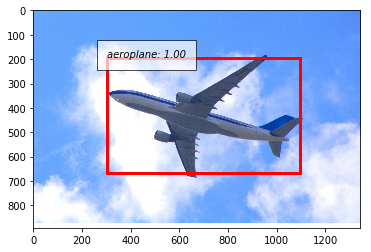

In [15]:
import chainercv
from chainercv import utils
from chainercv.datasets import voc_bbox_label_names
from chainercv.visualizations import vis_bbox

model = chainercv.links.SSD512(n_fg_class=len(voc_bbox_label_names), pretrained_model='voc0712')
img = utils.read_image('airplane.jpg', color=True)
bboxes, labels, scores = model.predict([img])
vis_bbox(img, bboxes[0], labels[0], scores[0], label_names=voc_bbox_label_names)

# まとめ

![Summary](https://image.slidesharecdn.com/handsonpart-190528034902/95/2019524-chainer-36-638.jpg)